# 导入工具

In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
%matplotlib inline

import jieba
import jieba.analyse
import jieba.posseg as pseg

import json
from gensim.models import FastText, Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine
import networkx as nx

from functools import reduce, partial, wraps
from collections import Counter, defaultdict
from itertools import combinations

In [4]:
'hello?wolrd.heloo'.split('dd')

['hello?wolrd.heloo']

---

In [2]:
pre_trained_wiki_model = r"D:\Github\NLP\Projects\data\trained_models\wiki_ltp_model.model"
wiki_model = Word2Vec.load(pre_trained_wiki_model)

In [326]:
raw_df = pd.read_csv('data/sqlResult_1558435.csv', encoding='gb18030')

In [327]:
raw_df.tail(2)

,id,author,source,content,feature,title,url
89609,2,夏文辉,新华社,\n\n2017年5月25日，在美国马萨诸塞州剑桥市，哈佛大学毕业生在毕业典礼上欢呼。（新华...,"{""type"":""其它"",""site"":""新华社"",""url"":""http://home.x...",哈佛大学为何取消这些新生入选资格？,http://home.xinhua-news.com/gdsdetailxhsnew/22...
89610,1,王子江 张寒,新华社,新华社德国杜塞尔多夫６月６日电题：乒乓女球迷 \n 新华社记者王子江、张寒\n 熊老...,"{""type"":""体育"",""site"":""新华社"",""url"":""http://home.x...",（体育）题：乒乓女球迷,http://home.xinhua-news.com/gdsdetailxhsnew/22...


## 数据预处理

In [350]:
%%time
for x in range(int(1e7)):
    re.sub('hello', 'what', 'hello world')

Wall time: 20.6 s


In [351]:
%%time
for x in range(int(1e7)):
    'hello world'.replace('hello', 'what')

Wall time: 3.22 s


Don't use regex unless necessary

In [2]:
def clean_df_pipe(raw_data):
    df = raw_data.copy()
    df.dropna(subset=['content'],inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.id = df.index
    return df

In [3]:
def string_pipe(string):
    string = string.replace(r'\r\n\u3000', ' ')
    string = string.replace('\\n', '')
    string = ' '.join(jieba.cut(string))
    string = re.sub(r'\s+', ' ', string)
    return string

In [4]:
def raw_summary(json_):
    try:
        result = json.loads(json_)['summary']
    except KeyError:
        result = ''
    return result

In [331]:
df = clean_df_pipe(raw_df)

In [242]:
df_clean = pd.DataFrame()
df_clean['content'] = df.content.apply(string_pipe)
df_clean['title'] = df.title
df_clean['summary'] = df.feature.apply(raw_summary)

In [337]:
df_clean = clean_df_pipe(df_clean)
df_clean.tail(2)

,content,title,summary
86050,2017 年 5 月 25 日 ， 在 美国 马萨诸塞州 剑桥市 ， 哈佛大学 毕业生 在 ...,哈佛大学为何取消这些新生入选资格？,2017年5月25日，在美国马萨诸塞州剑桥市，哈佛大学毕业生在毕业典礼上欢呼。（新华/欧新）...
86051,新华社 德国 杜塞尔多夫 ６ 月 ６ 日电 题 ： 乒乓 女球迷 新华社 记者 王子江 、...,（体育）题：乒乓女球迷,新华社德国杜塞尔多夫６月６日电 题：乒乓女球迷 新华社记者王子江、张寒 熊老师...


In [338]:
df_clean.to_csv('data/cleaned_data.csv', encoding='utf-8')

In [244]:
with open('data/corpus.txt', 'w', encoding='utf-8') as f:
    for content in df_clean.content:
        f.write(content+'\n')

---

In [26]:
df_clean = pd.read_csv('data/cleaned_data.csv', encoding='utf-8', index_col=0)
df_clean.tail()

,content,title,summary
86047,新华社 照片 ， 北京 ， 2017 年 6 月 7 日 电影 《 血战 湘江 》 举行 清...,（文化）（3）电影《血战湘江》举行清华大学巡映活动,新华社照片，北京，2017年6月7日 电影《血战湘江》举行清华大学巡映活动 6月6日，电影《...
86048,新华社 兰州 6 月 3 日电 （ 王衡 、 徐丹 ） 记者 从 甘肃省 交通运输 厅 获悉...,（经济）甘肃集中开工35个重点交通建设项目,新华社兰州6月3日电（王衡、徐丹）记者从甘肃省交通运输厅获悉，甘肃近日集中开建高速公路、普通...
86049,2017 年 5 月 29 日 ， 在 法国巴黎 郊外 的 凡尔赛宫 ， 法国 总统 马克 ...,法国议会选举 马克龙有望获“压倒性胜利”,2017年5月29日，在法国巴黎郊外的凡尔赛宫，法国总统马克龙出席新闻发布会。（新华/法新）...
86050,2017 年 5 月 25 日 ， 在 美国 马萨诸塞州 剑桥市 ， 哈佛大学 毕业生 在 ...,哈佛大学为何取消这些新生入选资格？,2017年5月25日，在美国马萨诸塞州剑桥市，哈佛大学毕业生在毕业典礼上欢呼。（新华/欧新）...
86051,新华社 德国 杜塞尔多夫 ６ 月 ６ 日电 题 ： 乒乓 女球迷 新华社 记者 王子江 、...,（体育）题：乒乓女球迷,新华社德国杜塞尔多夫６月６日电 题：乒乓女球迷 新华社记者王子江、张寒 熊老师...


In [27]:
df_clean.isna().sum()

content       0
title         0
summary    5560
dtype: int64

---

## 词向量

In [80]:
model = FastText(LineSentence('data/corpus.txt'), window=5, size=200, iter=10, min_count=10)

In [249]:
# 保存模型
# model.save('data/fasttext100.model')

In [81]:
# 只保存词向量
model.wv.save('data/fasttext100.kv')

In [91]:
model.wv.most_similar('系统')

[('对系统', 0.8728249073028564),
 ('子系统', 0.8571621179580688),
 ('门禁系统', 0.8418638706207275),
 ('存储系统', 0.8166689872741699),
 ('供水系统', 0.8127107620239258),
 ('电脑系统', 0.7942840456962585),
 ('信号系统', 0.7930917739868164),
 ('分系统', 0.7835454344749451),
 ('软件系统', 0.7818151116371155),
 ('电力系统', 0.7817472219467163)]

In [92]:
del model

---

## 词频统计

In [93]:
wv_from_kv = KeyedVectors.load('data/fasttext100.kv')

In [94]:
wv_from_kv.most_similar('总统')

[('周万鹏', 0.8395476341247559),
 ('代总统', 0.8130050897598267),
 ('俄总统', 0.7306485772132874),
 ('总统令', 0.725814938545227),
 ('总统大选', 0.7252855896949768),
 ('总统府', 0.704506516456604),
 ('总理', 0.6268736124038696),
 ('国务总理', 0.6221951246261597),
 ('新政府', 0.6127219200134277),
 ('司法部长', 0.5967322587966919)]

In [28]:
tokens = [word for doc in df_clean.content for word in doc.split()]

In [29]:
token_counter = Counter(tokens)

In [12]:
word_to_freq = {word:round(count/len(token_counter), 9) for word, count 
               in token_counter.items()}

In [13]:
word_to_freq_sorted = sorted(word_to_freq.items(), key=lambda x:x[1], reverse=1)
plot_length = 100
y = [value for _, value in word_to_freq_sorted]

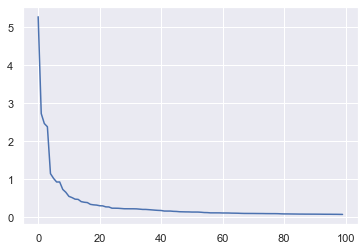

In [14]:
plt.plot(range(plot_length), y[:plot_length])
plt.show()

## PageRank

In [39]:
def pagerank(M, num_iteration=100, alpha=.85):
    N = M.shape[1]
    V = np.random.rand(N, 1)
    V = V / np.linalg.norm(V,1)
    iteration = 0
    while iteration < num_iteration:
        iteration += 1
        V = alpha * M @ V + (1-alpha) / N
    return V

In [40]:
M = np.array([[0, 0, 0, 0, 1],
              [0.5, 0, 0, 0, 0],
              [0.5, 0, 0, 0, 0],
              [0, 1, 0.5, 0, 0],
              [0, 0, 0.5, 1, 0]])
pagerank(M, .001)

array([[0.2  ],
       [0.115],
       [0.115],
       [0.285],
       [0.285]])

In [41]:
pagerank(M, 1)

array([[0.2  ],
       [0.115],
       [0.115],
       [0.285],
       [0.285]])

In [42]:
pagerank(M, 10)

array([[0.26212573],
       [0.13591249],
       [0.13591249],
       [0.19818968],
       [0.26785962]])

In [43]:
pagerank(M, 100)

array([[0.25419178],
       [0.13803151],
       [0.13803151],
       [0.20599017],
       [0.26375504]])

In [17]:
def generate_name(length=3):
    return ''.join(chr(np.random.randint(65, 73)) for _ in range(length)).capitalize()

In [18]:
graph = {
    'Yao': ['Guo', 'Wang', 'Tian', 'Tim'] + [generate_name() for _ in range(6)],
    'Guo': ['Li'] + [generate_name() for _ in range(5)],
    'Wang': ['Tian'] + [generate_name() for _ in range(5)],
    'Li': [generate_name() for _ in range(3)],
    'Tim': ['Tian'] + [generate_name() for _ in range(5)]
}

In [19]:
graph

{'Yao': ['Guo',
  'Wang',
  'Tian',
  'Tim',
  'Hdf',
  'Dgb',
  'Egc',
  'Ceg',
  'Fhb',
  'Fhb'],
 'Guo': ['Li', 'Faf', 'Efh', 'Caf', 'Ged', 'Hbg'],
 'Wang': ['Tian', 'Gdg', 'Bgh', 'Hhc', 'Adg', 'Gfg'],
 'Li': ['Fcf', 'Gbb', 'Feb'],
 'Tim': ['Tian', 'Fhg', 'Bbc', 'Egf', 'Bfc', 'Aae']}

In [20]:
social_nx = nx.Graph()

In [21]:
for vertex, edge in graph.items():
    for v in edge:
        social_nx.add_edges_from([(vertex, v)])

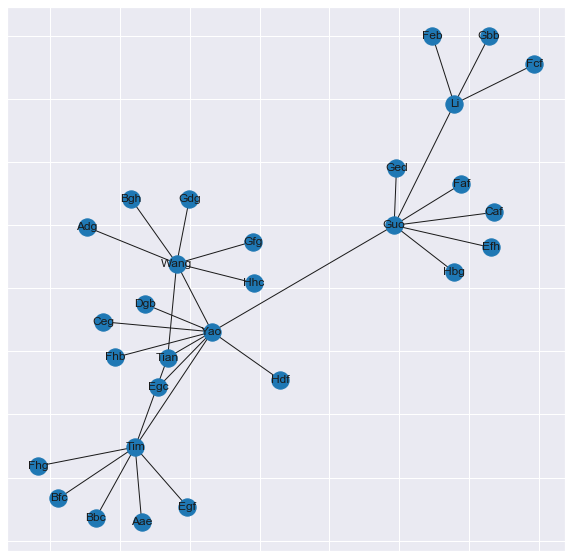

In [22]:
plt.figure(figsize=(10,10))
nx.draw_networkx(social_nx)
plt.show()

In [23]:
ranking_result = nx.pagerank(social_nx)

In [24]:
sorted(ranking_result.items(), key=lambda x: x[1], reverse=1)

[('Yao', 0.13267327585239913),
 ('Guo', 0.11272967851307805),
 ('Wang', 0.10768428320851282),
 ('Tim', 0.10768428320851282),
 ('Li', 0.06995860174040319),
 ('Tian', 0.04385427182289368),
 ('Fcf', 0.020039282976635146),
 ('Gbb', 0.020039282976635146),
 ('Feb', 0.020039282976635146),
 ('Faf', 0.018860451935758374),
 ('Efh', 0.018860451935758374),
 ('Caf', 0.018860451935758374),
 ('Ged', 0.018860451935758374),
 ('Hbg', 0.018860451935758374),
 ('Gdg', 0.0182480638615638),
 ('Bgh', 0.0182480638615638),
 ('Hhc', 0.0182480638615638),
 ('Adg', 0.0182480638615638),
 ('Gfg', 0.0182480638615638),
 ('Fhg', 0.0182480638615638),
 ('Bbc', 0.0182480638615638),
 ('Egf', 0.0182480638615638),
 ('Bfc', 0.0182480638615638),
 ('Aae', 0.0182480638615638),
 ('Hdf', 0.01770297168597297),
 ('Dgb', 0.01770297168597297),
 ('Egc', 0.01770297168597297),
 ('Ceg', 0.01770297168597297),
 ('Fhb', 0.01770297168597297)]

## TextRank（抽取式摘要）
两个应用
- 从句子中抽取句子关键词
    - 句子分词，用名词或者动词作为图结点，使用共现矩阵进行边构建
    - 使用page算法排序，取前N位进行组合后为句子关键字
- 从文档中抽取文档摘要（句子）
    - 文档分句，用单句作为图结点，句间相似度进行边构建
        - 句子相似度方法：
            - TextRank论文采用公式
                - ![s](./images/sentence_similarity.png)
            - StringKernel
            - 余弦距离（句向量）
            - 编辑距离
    - 同上方式取若干句作为文档摘要
        - 考虑：摘要的长度，TextRank进行文章摘要时，是以句子为基本单位进行处理，粒度较粗，适合有一定长度的文档
        - 因为摘要其实为内容中某些句子的集合，因此选取一定的比例的句子作为摘要，该参数可调，此处如论文中所示，20选4， 即五分之一，向上或下取整

### SentenceEmbedding
SIF-smooth inverse frequency
- 词频加权
- 语义无关向量去除
- ![sen2vec](./images/sif_sen2vec.png)

In [30]:
tokens_counter_all = Counter(tokens)
tokens_counter_notword = Counter([x for x in tokens if not x.isalpha()])
tokens_counter = tokens_counter_all - tokens_counter_notword

In [31]:
sum(tokens_counter.values())

15805787

In [55]:
with open('data/tokens_counter.json', 'w') as f:
    f.write(json.dumps(tokens_counter))

In [56]:
with open('data/tokens_counter.json', 'r') as f:
    temp = json.load(f)

In [32]:
# 越普遍的词汇权重越低
def word_weighted_prob(counter:dict, word, alpha=.001):
    denominator = sum(counter.values())
    try:
        prob = counter[word] / denominator
        weighted_prob = alpha / (alpha + prob)
    except KeyError:
        # 没见过的给最高权重
        return 1.0
    return weighted_prob

def word_weighted_wv(counter, wv, word):
    word_vec = wv[word]
    word_prob = word_weighted_prob(counter, word)
    return word_prob * word_vec

def compute_pc(X, npc=1):
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    pc = compute_pc(X, npc)
    update_X = X - X @ (pc.T @ pc)
    return update_X

def sen2vec(sentences:list, counter, wv):
    result = []
    sen2vec_dict = defaultdict(int)
    for sentence in sentences:
        words = list(filter(lambda x: x.isalpha(), jieba.cut(sentence)))
        vs = sum([word_weighted_wv(counter, wv, word) for word in words])
        result.append(vs)
        sen2vec_dict[sentence] = vs
    assert len(result) == len(sentences)
    X = np.array(result)
    final_X = remove_pc(X)
    return final_X, sen2vec_dict

In [33]:
def split_sentence(doc):
    pattern_space = re.compile('\s*')
    result = pattern_space.sub('',doc).split('。')
    return result[:-1] if result[:-1] else result

def similarity_with_coocurr(s1, s2, jieba_cut=True):
    # 取最长公共子序列commong_words时，短序列先遍历
    if len(s1) > len(s2):
        s1, s2 = s2, s1
    if jieba_cut:
        s1_words = list(filter(lambda x:x.isalnum(),list(jieba.cut(s1))))
        s2_words = list(filter(lambda x:x.isalnum(),list(jieba.cut(s2))))
    else:
        s1_words = list(s1)
        s2_words = list(s2)
    common_words = [word for word in s1_words if word in s2_words]
    numerator = len(common_words)
    # 防止出现分母为0
    denominator = np.log(len(s1_words)) + np.log(len(s2_words)) + .1
    return numerator / denominator

def get_sentences_edge(sentences:list, metrics, counter, wv):
    if len(sentences) == 1:
        return sentences
    
    if metrics.__name__ == 'cosine':
        _, sen2vec_dict = sen2vec(sentences, counter, wv)
        sentences = sen2vec_dict.keys()
        return [(s1, s2, metrics(sen2vec_dict[s1],sen2vec_dict[s2])) 
                for (s1, s2) in list(combinations(sentences, 2))]
    return [(s1, s2, metrics(s1,s2)) 
                for (s1, s2) in list(combinations(sentences, 2))]

def sumarization(sentences_with_edge, portion=.2):
    graph = nx.Graph()
    graph.add_weighted_edges_from(sentences_with_edge)
    rank = nx.pagerank(graph)
    sorted_rank = sorted(rank.items(), key=lambda x: x[1], reverse=True)
    summary_length = int(np.floor(len(graph.nodes) * portion))
    summary_length = summary_length if summary_length else 1
    result = [x[0] for x in sorted_rank[:summary_length]]
    return '；'.join(result) + '。'

def process_pipe(doc, metrics, counter, wv):
    split = split_sentence(doc)
    if len(split) == 1:
        return split[0] + '。'
    edges = get_sentences_edge(split, metrics, counter, wv)
    return sumarization(edges)

In [39]:
doc = np.random.randint(0,len(df_clean))
# doc = 71088
print('title:', df_clean.title[doc])
print('----')
print('content:', df_clean.content[doc].replace(' ',''))
print('----')
print('raw summary:', df_clean.summary[doc])
print('----')
print('index:', doc)
print('extarct summary with occur:',process_pipe(df_clean.content[doc], 
                                     similarity_with_coocurr,
                                     tokens_counter, wv_from_kv))
print('----')
print('extarct summary with cosine:',process_pipe(df_clean.content[doc], cosine, 
                                    tokens_counter,
                                     wv_from_kv))

title: （新华简讯）专家：盼国共两党在共同政治基础上携手引领两岸关系克难前行
----
content: 新华社北京５月２１日电５月２０日，中共中央总书记习近平电贺吴敦义当选中国国民党主席，吴敦义复电表示感谢。上海台湾研究所常务副所长倪永杰、中国社科院台湾研究所副研究员汪曙申等专家２１日受访表示，双方在函电往来中重申了坚持“九二共识”共同政治基础。在当前形势下，中国国民党应为维护两岸关系和平发展发挥积极的建设性作用，国共两党应共同把握正确方向，引领两岸关系克难前行，携手造福两岸同胞。（完）
----
raw summary: 　　新华社北京５月２１日电　５月２０日，中共中央总书记习近平电贺吴敦义当选中国国民党主席，吴敦义复电表示感谢。上海台湾研究所常务副所长倪永杰、中国社科院台湾研究所副研究员汪曙申等专家２１日受访表示，双方在函电往来中重申了坚持“九二共识”共同政治基础。在当前形势
----
index: 66657
extarct summary with occur: 上海台湾研究所常务副所长倪永杰、中国社科院台湾研究所副研究员汪曙申等专家２１日受访表示，双方在函电往来中重申了坚持“九二共识”共同政治基础。
----
extarct summary with cosine: 新华社北京５月２１日电５月２０日，中共中央总书记习近平电贺吴敦义当选中国国民党主席，吴敦义复电表示感谢。


### 关键字抽取

In [13]:
# 将文档视为长句进行关键字提取
# 分词->过滤标点->构建矩阵
def co_occurrence(doc, window_size=2):
    result = defaultdict(int)
    filtered = [word.word for word in pseg.cut(doc.replace(' ','')) 
                if word.flag in ['v','n'] if len(word.word) > 1]
#     filtered = list(filter(lambda x: x.isalnum(), doc.split()))
#     filtered.insert(0,'BOS')
#     filtered.append('EOS')
    max_length = len(filtered)
    
    for i, word in enumerate(filtered):
        start = i - window_size if (i - window_size) > 0 else 0
        end = i + window_size + 1 if  i + window_size + 1 < max_length else max_length
        candidates = filtered[start:end]
        candidates.remove(word)
        if candidates:
            for c in candidates:
                result[(word, c)] += 1
    return [(k[0], k[1], v) for k, v in result.items()]

def extract_keyword(co_list, topk=20):
    graph = nx.Graph()
    graph.add_weighted_edges_from(co_list)
    sorted_ = sorted(nx.pagerank(graph).items(), key=lambda x:x[1], reverse=True)[:topk]
    return [x[0] for x in sorted_]

In [14]:
s = df_clean.content[np.random.randint(0, len(df_clean))]
print(s.replace(' ', ''))
# 跟jieba api比较还有些差距，权重方面需要细调
# 暂用api进行后面项目构建
extract_keyword(co_occurrence(s,5))

新华社照片，青岛（山东），2017年4月10日（体育）（7）游泳——全国游泳冠军赛开赛4月10日，浙江队选手孙杨在男子400米自由泳预赛中，最终他以3分47秒95的成绩晋级决赛。当日，2017年全国游泳冠军赛暨第十三届全运会预赛在山东青岛体育中心游泳馆开赛。新华社记者夏一方摄


['全国', '冠军赛', '决赛', '成绩', '男子', '选手', '体育中心', '游泳馆', '记者', '照片']

[jieba API](https://github.com/fxsjy/jieba)

In [15]:
# 基于textrank的关键词抽取
jieba.analyse.textrank(s)

['青岛', '山东', '游泳', '冠军赛', '体育中心', '开赛', '成绩', '决赛', '全国', '游泳馆', '预赛', '照片']

In [16]:
# 基于tf-idf的关键词抽取
jieba.analyse.extract_tags(s,allowPOS=('n','v'))

['冠军赛', '游泳馆', '体育中心', '全国', '决赛', '选手', '照片', '成绩', '男子', '记者']

## todo
- 利用文章标题（如果有的话）
- 将文档看成长句，用TextRank进行关键字提取，对含关键字的句子赋予更多权重
    - 构建共现矩阵实现
    - 构建字典实现
- 关注文章的一些特殊位置，比如开头和结尾
- 集合LDA主题模型进行优化
- KNN?